# University of Southampton Digital Library Search API

First import Python packages we'll need. Some are built in like subprocess and sys. Others, such as Requests, need to be downloaded from the Python package manager PIP. We check if the Requests package is already installed and if it isn't found, we install it with PIP.

In [1]:
import json
import subprocess
import sys

# Ensure 'requests' is installed and imported
try:
    import requests
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"])
    import requests


We're going to follow an example from the [API documentation](https://digital.epexio.com/uosViewer/repositories/records/search.html), searching for records in the [Digital Viewer](https://viewer.soton.ac.uk/) that have the word "balloon" in the title.

In [21]:
# Build query

def build_query_url(search_term, field, offset=None, limit=10):
    end_point = "https://digital.epexio.com/uosViewer/repositories/records/search"
    query_string = "?q=" + search_term + "&field=" + field + "&limit=" + str(limit)
    if offset:
        query_string += "&offset=" + str(offset)

    query = end_point + query_string 
    # evaluates to https://digital.epexio.com/uosViewer/repositories/records/search?q=balloon&field=title&limit=10
    # you could copy and paste this url into a browser and display the data returned by the API
    return query


In [22]:
# Send query
query = build_query_url('balloon', 'title')
response = requests.get(query)

In [10]:
# view the response
formatted_json = json.dumps(response.json(), indent=4)
print(formatted_json)

{
    "header": {
        "hitCount": 4
    },
    "records": [
        {
            "uri": "http://data.epexio.com/uosViewer/descriptions/02f7a64f-5e5c-4101-b544-93516bf0244f",
            "locator": "epexio:loc:uosViewer:descriptions/MS439_A4278_HFA_8_3_1_46",
            "oai_identifier": "oai:data.epexio.com:uosViewer/descriptions/02f7a64f-5e5c-4101-b544-93516bf0244f",
            "refNo": "MS439_A4278_HFA_8_3_1_46",
            "title": "One scuba diver carrying a concrete block underwater with a lifting balloon",
            "last_modified": "2024-06-06T09:05:11.851Z",
            "date": "1970-1973",
            "dateRange": null,
            "description": null,
            "dc": {
                "title": "One scuba diver carrying a concrete block underwater with a lifting balloon",
                "description": null,
                "type": "Archive Collection",
                "identifier": "http://data.epexio.com/uosViewer/descriptions/02f7a64f-5e5c-4101-b544-93516bf0244f

Let's explore the data and extract some values. We can start by printing out how many hits our search returned.

In [11]:
# get the response body json as a Python dictionary and put it in a variable called "data".
data = response.json()

# Access the hit count using square bracket notation. Get the value of the 'header' key (the hit count and count key/vaue pair)
# then get the count value from the 'hitCount' key. Put the value in a variable called "number_of_hits".
number_of_hits = data['header']['hitCount']

# Use a formatted string to insert the number of hits into a string and print it out.
print(f'The search had {number_of_hits} hits.')

The search had 4 hits.


Next lets get the title and dates of each of the 4 records and print them out.

In [12]:
# get the records from the data variable and loop over them, extracting the title and dates,
# then print them out

records = data['records']

for record in records:
    title = record['title']
    date = record['date']
    print(f'{title} | {date}')

One scuba diver carrying a concrete block underwater with a lifting balloon | 1970-1973
Two scuba divers carrying a heavy artefact underwater with a lifting balloon | 1970-1973
Aerial survey using a balloon mounted camera | c.1967-1994
One scuba diver carrying a heavy artefact underwater with a lifting balloon | 1970-1973


Let's try searching for records that have "education" but not "Ireland" in the text. We can reuse the "build_query_url" function. This time we can search the indexed text and see how many hits we get.

In [23]:
query = build_query_url('education -Ireland', 'content')
response = requests.get(query)

data = response.json()

number_of_hits = data['header']['hitCount']

print(f'The search had {number_of_hits} hits.')

The search had 147 hits.


This search has resulted in quite a large number of hits. Rather than printing out all of the results we can get an idea of what the data looks like by looking at samples.

In [24]:
# look at the record in position 4 in the list of results
records = data['records']
print(json.dumps(records[4], indent=4))

{
    "uri": "http://data.epexio.com/uosViewer/descriptions/03e185e0-488d-4caf-b6e7-23beea21ae95",
    "locator": "epexio:loc:uosViewer:descriptions/ao-op1266254-1001",
    "oai_identifier": "oai:data.epexio.com:uosViewer/descriptions/03e185e0-488d-4caf-b6e7-23beea21ae95",
    "refNo": "ao-op1266254-1001",
    "title": "Certificate of secondary education : a proposal for a new school leaving certificate other than the G.C.E.",
    "last_modified": "2021-09-22T11:28:26.380Z",
    "date": "1961",
    "dateRange": "1961-1961]",
    "description": null,
    "dc": {
        "title": "Certificate of secondary education : a proposal for a new school leaving certificate other than the G.C.E.",
        "description": null,
        "type": "Archive Collection",
        "identifier": "http://data.epexio.com/uosViewer/descriptions/03e185e0-488d-4caf-b6e7-23beea21ae95",
        "subjects": [],
        "coverage": [],
        "relation": [
            "https://viewer.soton.ac.uk/records/ao-op1266254

In [25]:
# Try to look at the record in position 57 in the list of results
print(json.dumps(records[57], indent=4))

IndexError: list index out of range

Trying to look at the record at position 57 resulted in an IndexError. This means that there is no position 57. We know that our query had 147 hits, so there should be a position in the list of results for each of the hits. Let's look at how many records have actually been returned.

In [26]:
print(len(records))

10


We only have 10 of the 147 records. Looking at the [API documentation](https://digital.epexio.com/uosViewer/repositories/records/search.html), we see that one of the API parameters is "limit", which specifies the maximum number of records to return. This can be a number between 1 and 500 and defaults to 10. We could resend the query and specify a higher limit but what if we don't know how many results there will be? It would be better to request the results in batches. Fortunately the API has a parameter "offset", which takes a number larger than 0 to be the starting place for the results that are returned.

In [27]:
records = [] # we will add the records to this list as they are returned
query = build_query_url('education -Ireland', 'content')
response = requests.get(query)

data = response.json()
number_of_hits = data['header']['hitCount']
batch_size = 10 # this is the number of hits we want to recieve each time we query the API

# we add the first 10 hits to the records list, meaning the next call to the API will need to start from 10
records.extend(data['records'])

# range is part of the standard Python library that generates a series of numbers.
# It takes a starting number, a number to stop at and a number to count up with.
# We will start from 10 as we've already got the first 10 results, we will stop counting when we have
# all of the hits and because we want batches of 10 records, we'll count up in 10s

for offset in range(batch_size, number_of_hits, batch_size):# this is the same as range(10, 147, 10)
    query = build_query_url('education -Ireland', 'content', offset=offset)
    response = requests.get(query)
    data = response.json()
    records.extend(data['records'])
    
    
print(len(records))

# it may take a few minutes to fetch all of the records

147


In [29]:
# lets try looking at position 57 again

print(json.dumps(records[57], indent=4))

{
    "uri": "http://data.epexio.com/uosViewer/descriptions/731bab6c-7f9d-43a8-bf19-36b47cb8286a",
    "locator": "epexio:loc:uosViewer:descriptions/ao-op1279778-1001",
    "oai_identifier": "oai:data.epexio.com:uosViewer/descriptions/731bab6c-7f9d-43a8-bf19-36b47cb8286a",
    "refNo": "ao-op1279778-1001",
    "title": "Education : common funding formula for self-governing (GM) schools 1995-96 [consultation paper]",
    "last_modified": "2021-09-22T13:29:58.802Z",
    "date": "1994",
    "dateRange": "1994-1994]",
    "description": null,
    "dc": {
        "title": "Education : common funding formula for self-governing (GM) schools 1995-96 [consultation paper]",
        "description": null,
        "type": "Archive Collection",
        "identifier": "http://data.epexio.com/uosViewer/descriptions/731bab6c-7f9d-43a8-bf19-36b47cb8286a",
        "subjects": [],
        "coverage": [],
        "relation": [
            "https://viewer.soton.ac.uk/records/ao-op1279778-1001"
        ]
    }

After sampling the records, we may decide that we want to do more analysis with these records but don't want to download them from the API repeatedly. Instead, let's create a function we can use to save the records to a json file.

In [31]:
def save_records(records, filename="records.json"):
    with open(filename, 'w') as fout:
        json.dump(records, fout, indent=4)
        
save_records(records)

Let's also create a function we can use to open the file.

In [32]:
def open_records(filename):
    with open(filename, 'r') as fin:
        return json.load(fin)
    
records_from_file = open_records("records.json")

# Let's check that the number of records we get back from the file are
# the same as we put into the file.
print(len(records_from_file))

147


We saw from the title of the record in position 57 of the records list that the record is for a consultation paper. Let's create a visualisation that shows what percentage of the records are for consultations.

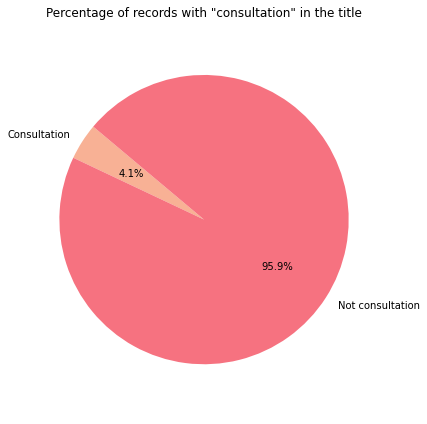

In [37]:
# import the matplotlib library
import matplotlib.pyplot as plt

# count how many record titles contain the word 'consultation'
matching_count = sum(
    1 for record in records_from_file
    if 'consultation' in record['title'].lower()# checks if the word 'consultation is in the title of the current record'
)
records_count = len(records_from_file)
not_matching_count = records_count - matching_count

matching_percentage = (matching_count / records_count) * 100 if records_count > 0 else 0

# create the pie chart
labels = ['Consultation', 'Not consultation']
sizes = [matching_count, not_matching_count]
colours = ['#f8b195', '#f67280']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colours, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of records with "consultation" in the title')
plt.axis('equal')
plt.tight_layout()
plt.show()